# COMPUTER VISION ASSIGNMENT 3

####  OPTICAL FLOW

In this project, you will implement the Lucas-Kanade and Horn-Schunck optical flow methods. Both methods are based on spatial and temporal derivatives, differing mainly in the optimization approach.

In [124]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.color import rgb2gray
import matplotlib.patches as patches

In [125]:
def importImage(path, resize):
    #status:complete
    #task: imports image, converts it into grayscale and returns image, #rows, #cols
    #parameter: path, resize=true/false
    #returns: grayscaled image
    
    im = io.imread(path)
    im = rgb2gray(im)
    if(resize==True):
        scale_percent = 50 # percent of original size
        width = int(im.shape[1] * scale_percent / 100)
        height = int(im.shape[0] * scale_percent / 100)
        dim = (width, height)
        im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)

    im = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) *1.0)).astype('float')
    return im

In [126]:
def adjustInputs(image, Mask):
    #status: complete
    #task: adjust inputs by padding
    #parameters: image, Mask=kernel
    #returns: x pad size, y pad size, Mask
    #output_size= (input_size- filter_size + 2*Padding_size)+1
    #if input and output size are same: then Padding_size=(filter_size-1)/2 (ceil it)
      
    (init_x_size, init_y_size)=image.shape
    Mask=np.flipud(np.fliplr(Mask))
    x_pad_size=math.ceil((Mask.shape[0]-1)/2)
    y_pad_size=math.ceil((Mask.shape[1]-1)/2)
    pad_sizes=[x_pad_size, y_pad_size]    
    image=np.pad(image, (max(pad_sizes)), mode='constant')
    
    return x_pad_size, y_pad_size, image, Mask, max(pad_sizes)

In [127]:
def CommonUtil(image, init_x_size, init_y_size, max_pad, x_pad, y_pad, Mask, isGrad):
    #status: complete
    #task: utility function to multiply kernel to image patch
    #output: adjusted image
    
    if(isGrad):
        grad_output_image= np.zeros((init_x_size+2*y_pad, init_y_size+2*x_pad))
    else:
        grad_output_image= np.zeros((init_x_size, init_y_size))

    out_row=0
    out_col=0
    
    for x_pivot in range(x_pad, init_x_size+x_pad):
        out_col=0
        for y_pivot in range(y_pad, init_y_size+y_pad):
            patch=image[x_pivot-max_pad: x_pivot+max_pad+1, y_pivot-max_pad: y_pivot+max_pad+1]            
            grad_output_image[out_row][out_col] = np.sum(np.multiply(Mask, patch))
            out_col+=1
        out_row+=1
    return grad_output_image

In [128]:
def Convolve(image, Mask):
    #status: complete
    #task: perform Convolution or CrossCorrelation 
    #parameters: image, Mask=kernel, opType= True if Convolution False if CrossCorrelation
    #returns: convolved image
    
    (init_x_size, init_y_size)=image.shape
    x_pad, y_pad, image, Mask, max_pad=adjustInputs(image, Mask)   
    output_image= CommonUtil(image, init_x_size, init_y_size, max_pad, x_pad, y_pad, Mask, False)
    return output_image

In [129]:
def FindDerivativeImages(image, xDerivativeMask, yDerivativeMask):
    #status: complete
    #task: finds x and y derivatives, magnitude of the derivatives of the image
    #parameters: image, xDerivative, yDerivative
    #returns: xgradient, ygradient, magnitude
    
    init_x_size, init_y_size=image.shape
    
    x_pad, y_pad, ximage, xDerivativeMask, max_pad=adjustInputs(image, xDerivativeMask)
    xgrad_output_image = CommonUtil(ximage, init_x_size, init_y_size, max_pad, x_pad, y_pad, xDerivativeMask, True)

    x_pad, y_pad, yimage, yDerivativeMask, max_pad=adjustInputs(image, yDerivativeMask)
    ygrad_output_image = CommonUtil(yimage, init_x_size, init_y_size, max_pad, x_pad, y_pad, yDerivativeMask, True)
    
    return xgrad_output_image, ygrad_output_image

In [130]:
def displayCorner(nRows, nCols, imgArray, nameArray):
    #status: complete
    #params: nrows, ncols, images array, names of the images,  
    #returns: subplots of given format
    
    c = 1  # initialize plot counter
    fig = plt.figure(figsize=(14,10))
    for i in imgArray:
        plt.subplot(nRows, nCols, c)
        plt.title(nameArray[c-1])
        plt.imshow(imgArray[c-1], cmap='gray')
        c = c + 1
    plt.show()

In [131]:
def optical_flow_kankade(image1, image2, frame_size):
    #status: complete
    #params: img2, img2, neighborhood size
    #returns: LUCAS OPTICAL FLOW ARRAYS u, v
    
    x_sobel_filter=(np.array([[-1, 0, 1]]))
    y_sobel_filter=np.array([[-1, 0, 1]]).T
    
    flowsx=[]
    flowsy=[]
    for i in range(frame_size//2, image1.shape[0]-frame_size//2+1):
        out_rowx=[]
        out_rowy=[]
        for j in range(frame_size//2, image1.shape[1]-frame_size//2+1):
            frame1=[]
            frame2=[] 
            A=[]#for every fs**2 points
            B=[]
            
#             print(-frame_size//2, frame_size//2)
            for k in range(-frame_size//2, frame_size//2):
                flow_row1=[]
                flow_row2=[]
                for l in range(-frame_size//2, frame_size//2):
                    flow_row1.append(image1[i+k][j+l])
                    flow_row2.append(image2[i+k][j+l])
                frame1.append(flow_row1)
                frame2.append(flow_row2)
            
            Ix, Iy=np.gradient(np.matrix(frame1, dtype='float'))            
#             print(Ix.shape, Iy.shape)
            
            Ix=np.reshape(Ix, (frame_size**2, 1))
            Iy=np.reshape(Iy, (frame_size**2, 1))
            
            A=np.hstack((Ix, Iy))
#             A=np.squeeze(A, axis=0)
            It=np.matrix(frame2, dtype='float')-np.matrix(frame1,  dtype='float')
            B=-1*np.reshape(It, (frame_size**2, 1))
#             B=np.squeeze(B, axis=0)
#             print(np.linalg.lstsq(A, B))
            linalg=np.linalg.lstsq(A, B)[0]
            u, v=(linalg[0][0], linalg[1][0])
            out_rowx.append(u)
            out_rowy.append(v)
        flowsx.append(out_rowx)
        flowsy.append(out_rowy)
    return np.array(flowsx), np.array(flowsy)

In [236]:
def print_vectors(im1, subsample, x, y, frame_size, HS, lbda=0.01, epoches=1000):
    #status: complete
    #params: img2, subsample, u, v flow vectors, neighborhood size
    #returns: quiver plot of u, v vectors
    
    rows=im1.shape[0]
    cols=im1.shape[1]
    sub_u = y[0:rows:subsample, 0:cols:subsample]
    sub_v = -x[0:rows:subsample, 0:cols:subsample]
    xc = np.linspace(0, cols, sub_u.shape[1])#changed rows
    yc = np.linspace(0, rows, sub_v.shape[0])
    # Locations of the vectors
    xv, yv = np.meshgrid(xc, yc)
    fig1 = plt.figure(figsize = (10,7))
    plt.imshow(im1 ,cmap = 'gray')
    if(HS==False):
        plt.title('LUCAS Optical Flow with Frame size: '+str(frame_size)), plt.xticks([]), plt.yticks([])
    else:
        plt.title('Optical Flow Vectors for lamda = ' + str(lbda) + " epochs = "+ str(epoches))
    # Plot the vectors
    plt.quiver(xv, yv, sub_u, sub_v, color='y')

In [248]:
def calcUtil(frame1, frame2):
    #status: complete
    #task: calculates Ix, Iy, It
    
    Ix=(1/4)*(frame1[1][0]+frame2[1][0]+frame1[1][1]+frame2[1][1]) - (1/4)*(frame1[0][0]+ frame2[0][0] + frame1[0][1]+frame1[0][1])
    Iy=(1/4)*(frame1[0][1]+frame2[0][1]+frame1[1][1]+frame2[1][1]) - (1/4)*(frame1[0][0]+ frame2[0][0] + frame1[1][0]+frame2[1][0])
    It=(1/4)*(frame2[0][0]+frame2[0][1]+frame2[1][0]+frame2[1][1]) - (1/4)*(frame1[0][0]+ frame1[0][1] + frame1[1][0]+frame1[1][1])
    return Ix, Iy, It

In [249]:
def utility_flow(image1, image2, U, V):
    #status:complete
    #task: computes u, v
    
    flowsx=[]
    flowsy=[]
    for i in range(0, image1.shape[0]-1):
        out_rowx=[]
        out_rowy=[]
        for j in range(0, image1.shape[1]-1):
            frame1=[]
            frame2=[] 
            A=[]#for every fs**2 points
            B=[]
            for k in range(0, 2):
                flow_row1=[]
                flow_row2=[]
                for l in range(0, 2):
                    flow_row1.append(image1[i+k][j+l])
                    flow_row2.append(image2[i+k][j+l])
                frame1.append(flow_row1)
                frame2.append(flow_row2)
            
            Ix, Iy, It=calcUtil(frame1, frame2)
            numerator = (Ix*U[i][j] + Iy*V[i][j] + It)
            denominator = (lbda**2 + Ix**2 + Iy**2)
            U[i][j] = U[i][j] - Ix*(numerator/denominator) 
            V[i][j] = V[i][j] - Iy*(numerator/denominator) 
    return U, V

In [273]:
def HornSchunckFlow(img1, img2, lbda, epochs):
    #status: complete
    #params: image1, image2, lambda, epochs
    #returns: U, V calculated using Horn Schunck process
    
    U, V = (np.zeros((img1.shape[0], img1.shape[1])), np.zeros((img1.shape[0],img1.shape[1])))
    for epoch in range (epochs):
#         print(epoch)
        U, V=utility_flow(img1, img2, U, V)
    return U, V

In [274]:
def HornSchunckOpticalFlow(img1, img2, lbda, epoches):
    #status:complete
    #task: computes u, v optical flow vectors
    #params: image1, image2, lambda, epoches
    
    HornSchunckKernel = np.array([[0, 1/4, 0],
                   [1/4,    0, 1/4],
                   [0, 1/4, 0]], float)
    
    U, V = (np.zeros((img1.shape[0], img1.shape[1])), np.zeros((img1.shape[0],img1.shape[1])))
    x_sobel_filter=((1/4)*np.array([[-1, 0, 1]]))
    y_sobel_filter=((1/4)*np.array([[-1, 0, 1]]).T)
    Temporal_filter=((1/4)*np.array([[1, 1, 1]]))
    fx = Convolve(img1, x_sobel_filter)
    fy = Convolve(img1, y_sobel_filter)
    ft= Convolve(img1, Temporal_filter) + Convolve(img2, -Temporal_filter)
    
    for epoch in range(epoches):
        uTemp = Convolve(U, HornSchunckKernel)
        vTemp = Convolve(V, HornSchunckKernel)
#         print(epoch)
        numerator = (fx*uTemp + fy*vTemp + ft)
        denominator = (lbda**2 + fx**2 + fy**2)
        
        U = uTemp-fx*(numerator/denominator)
        V = vTemp-fy*(numerator/denominator)
    
    return U, V

In [279]:
def main(image_paths, resize):
    status: incomplete
    params: conv_image_path= image path for convolution, filter_size= filter size
    1. partial derivative using sobel
    
    image1=importImage(image_path[0], resize)
    x_sobel_filter=(np.array([[-1, 0, 1]]))
    y_sobel_filter=np.array([[-1, 0, 1]]).T
    xGradImage, yGradImage = FindDerivativeImages(image1, x_sobel_filter, y_sobel_filter) 
    image2=importImage(image_path[1], resize)
    temp_diff=image1-image2
    image_list=[image1, image2, xGradImage, yGradImage, temp_diff]
    names_list=["I-Image Imported", "II-Image Imported", "xGradient", "yGradient", "temporal partial derivative"]
    displayCorner(2, 3, image_list, names_list)

    
    #2. LUCAS KANADE
    frame_sizes=[7, 7]
    for frame_size in frame_sizes:
        image1=importImage(image_path[0], resize)
        image2=importImage(image_path[1], resize)
        x, y=optical_flow_kankade(image1, image2, frame_size)
        y=np.squeeze(y)
        x=np.squeeze(x)
        plt.imshow(x, cmap='gray')
        plt.imshow(y, cmap='gray')
        plt.title("LUCAS KANADE MAGNITUDE WITH FRAME SIZE: " + str(frame_size))
        image1=importImage(image_path[0], resize)
        print_vectors(image1, 5, x, y, frame_size, False)
    
    #3.HORN SCHUNK
    
    image1=importImage("sphere0.png", False)
    image2=importImage("sphere1.png", False)
    lbda=0.1
    epochs=8
    U, V = HornSchunckFlow(image1, image2, lbda, epochs)
    plt.imshow(U, cmap='gray')
    plt.imshow(V, cmap='gray')
    plt.title('Optical Flow Magnitude for lambda = 10, epoches = 500'), plt.xticks([]), plt.yticks([])    
    print_vectors(image1, 10, U, V, " ", True, lbda, epoches)

#     image1=importImage(image_path[0], False)
#     image2=importImage(image_path[1], False)
#     lbda=100
#     epoches=1000
#     U, V = HornSchunckOpticalFlow(image1, image2, lbda, epoches)
#     plt.imshow(U, cmap='gray')
#     plt.imshow(V, cmap='gray')
#     plt.title('Optical Flow Magnitude for lambda = 0.1, epoches = 1000'), plt.xticks([]), plt.yticks([])
#     print_vectors(image1, 10, U, V, " ", True, lbda, epoches)


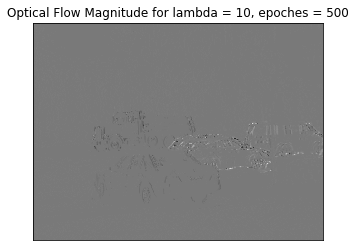

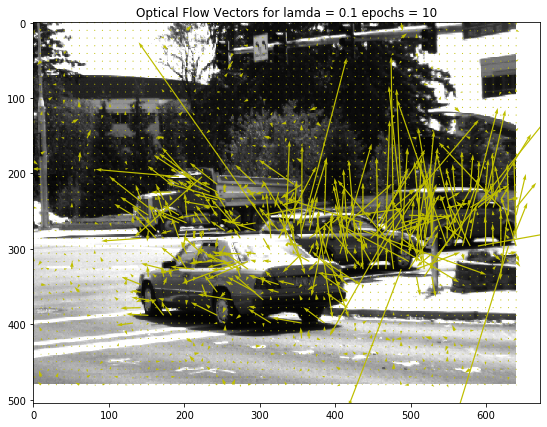

In [280]:
if __name__=="__main__":
    image_path=["sphere0.png", "sphere1.png"]
    main(image_path, True)